In [1]:
import numpy as np
import pandas as pd

''' data cleanning '''
import texthero as hero
from texthero import preprocessing

''' model building and evaluation '''
from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV
from sklearn.metrics import f1_score, accuracy_score, plot_confusion_matrix, precision_score, recall_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

''' Evaluation '''
from yellowbrick.model_selection import LearningCurve
from yellowbrick.classifier import PrecisionRecallCurve
from yellowbrick.classifier import ClassPredictionError
from yellowbrick.classifier import ClassificationReport

''' Plotting '''
import matplotlib
import matplotlib.pyplot as plt

from mlxtend.plotting import plot_learning_curves

''' Export model '''
import pickle

plt.style.use('classic')
matplotlib.rcParams['figure.figsize'] = (20, 10)

In [2]:
# columns that we use
cols = ['EventDescription','IncidentCause','IncidentConsequence','Category']

# importing file
df = pd.read_csv('..\..\cleaned_incidents1.csv', usecols=cols)

# drop missing category
df = df.dropna(axis=0, subset=['Category'])

# replace the rest with empty string
df = df.replace(np.nan, '', regex=True)

In [3]:
# Text Cleaning and Pre-processing
def preprocess_text(features):
    # cleaning steps
    cleaning_pipeline = [
        preprocessing.fillna,
        preprocessing.lowercase,
        preprocessing.remove_whitespace,
        preprocessing.remove_punctuation,
        preprocessing.remove_urls,
        preprocessing.remove_brackets,
        preprocessing.remove_stopwords,
        preprocessing.remove_digits,
        preprocessing.remove_angle_brackets,
        preprocessing.remove_curly_brackets,
        preprocessing.stem
    ]

    # apply pipeline to text
    clean_text = features.pipe(hero.clean, cleaning_pipeline)
    
    return clean_text

In [4]:
# cleaning the data
df['description'] = df['EventDescription'] + ' ' + df['IncidentCause']+ ' ' + df['IncidentConsequence']
df['description'] = preprocess_text(df['description'])

le = LabelEncoder()
Y = le.fit_transform(df['Category'])

# splitting of data in test and train
x_train,x_test, y_train, y_test = train_test_split(df['description'],Y, test_size=0.25, random_state = 42)

# vectorize
tfidf = TfidfVectorizer(analyzer='word', max_features=500)

tfidf.fit_transform(df['description']).toarray()
x_train = tfidf.transform(x_train)
x_test = tfidf.transform(x_test)

# dump tfidf
tfidf_pickle_name = 'TFIDF_500.pickle'
pickle.dump(tfidf, open(tfidf_pickle_name, 'wb'))

# resampling
oversample = SMOTE(random_state=0,n_jobs=-1,k_neighbors=5)
x_train, y_train = oversample.fit_resample(x_train, y_train)

In [5]:
plt.style.use('classic')
matplotlib.rcParams['figure.figsize'] = (20, 10)

# evaluation metrics for imbalanced data
def model_evaluation(model, x_train, y_train, x_test, y_test, model_name, y_pred):
    """:arg
    :model, classifier, must have .fit() and .predict()
    :x_train, X, features
    :y_train, y, target
    :x_test, test features
    :y_test, test target
    :model_name, name of the classifier, string
    :y_pred, prediction made by classifier
    """
    
    # constants
    sizes = np.linspace(0.3, 1.0, 10)

    # accuracy
    acc = accuracy_score(y_test, y_pred)
    print(f'The accuracy for {model_name}: {acc}')

    # F-measure
    f1score = f1_score(y_test, y_pred, average='micro')
    print(f'F-Measure for {model_name}: {f1score}')

    target_names = le.classes_
    
    # classification report
    visualizer = ClassificationReport(model, support=True, cmap='spectral', classes = target_names)
    visualizer.fit(x_train, y_train)        # Fit the visualizer and the model
    visualizer.score(x_test, y_test)        # Evaluate the model on the test data
    visualizer.show()

    # Generate confusion matrix
    matrix = plot_confusion_matrix(model, x_test, y_test, cmap=plt.cm.Blues, display_labels=target_names)
    plt.title(f'Confusion matrix for {model_name} classifier')
    plt.xticks(rotation=65)
    plt.show(matrix)
    plt.show()
    
    # precision recall curve
    viz = PrecisionRecallCurve(
        model,
        cmap="Set1",
        train_sizes=sizes,
        per_class=True,
        classes=target_names,
        colors=["purple", "cyan", "slategray", "red", "grey", "yellow", "maroon", "gold", "orange", "olive", "brown", "deeppink", 'darkkhaki', "black", "navy"]
    )
    viz.fit(x_train, y_train)
    viz.score(x_test, y_test)
    viz.show()

    # class prediction error
    visualizer = ClassPredictionError(
        model,
        classes=target_names,
        colors=["purple", "cyan", "slategray", "red", "grey", "yellow", "maroon", "gold", "orange", "olive", "brown", "deeppink", 'darkkhaki', "black", "navy"]
    )
    visualizer.fit(x_train, y_train)
    visualizer.score(x_test, y_test)
    visualizer.show()

    # Create the learning curve visualizer
    cv = StratifiedKFold(n_splits=10)
    visualizer = LearningCurve(
        model, cv=cv, scoring='f1_micro', train_sizes=sizes, n_jobs=4
    )
    visualizer.fit(x_train, y_train)      
    visualizer.show()

    # learning curve with train and test data
    plot_learning_curves(x_train, y_train, x_test, y_test, model, train_marker='o', test_marker='^',
                     scoring='misclassification error', suppress_plot=False, print_model=True, legend_loc='best')


In [32]:
# experiment with 500 features and weight param, the result is good
# experiment with 250 features and params from optimatisation, the result is clearly overfitting, the trainning error is flat at 0

def CreateBalancedSampleWeights(y_train, largest_class_weight_coef):
    classes = np.unique(y_train, axis = 0)
    classes.sort()
    class_samples = np.bincount(y_train)
    total_samples = class_samples.sum()
    n_classes = len(class_samples)
    weights = total_samples / (n_classes * class_samples * 1.0)
    class_weight_dict = {key : value for (key, value) in zip(classes, weights)}
    class_weight_dict[classes[1]] = class_weight_dict[classes[1]] * largest_class_weight_coef
    sample_weights = [class_weight_dict[y] for y in y_train]
    return sample_weights

largest_class_weight_coef = max(df['Category'].value_counts().values)/df.shape[0]
weight = CreateBalancedSampleWeights(y_train, largest_class_weight_coef)

xgb = XGBClassifier(random_state=4, num_class=15, early_stopping_rounds=10, weights = weight) #500 features with weight
# xgb = XGBClassifier(random_state=4, num_class=15, early_stopping_rounds=10, weights = weight
#     ,gamma= 0.1, learning_rate= 0.1, max_depth= 20, subsample= 0.7) #test 2 - 250 features, clearly overfitting

xgb.fit(x_train, y_train)
y_pred = xgb.predict(x_test)

The accuracy for xgBoost: 0.8083795440542206
F-Measure for xgBoost: 0.8083795440542206


C:\Users\Mama\apps\Anaconda3\lib\site-packages\sklearn\base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


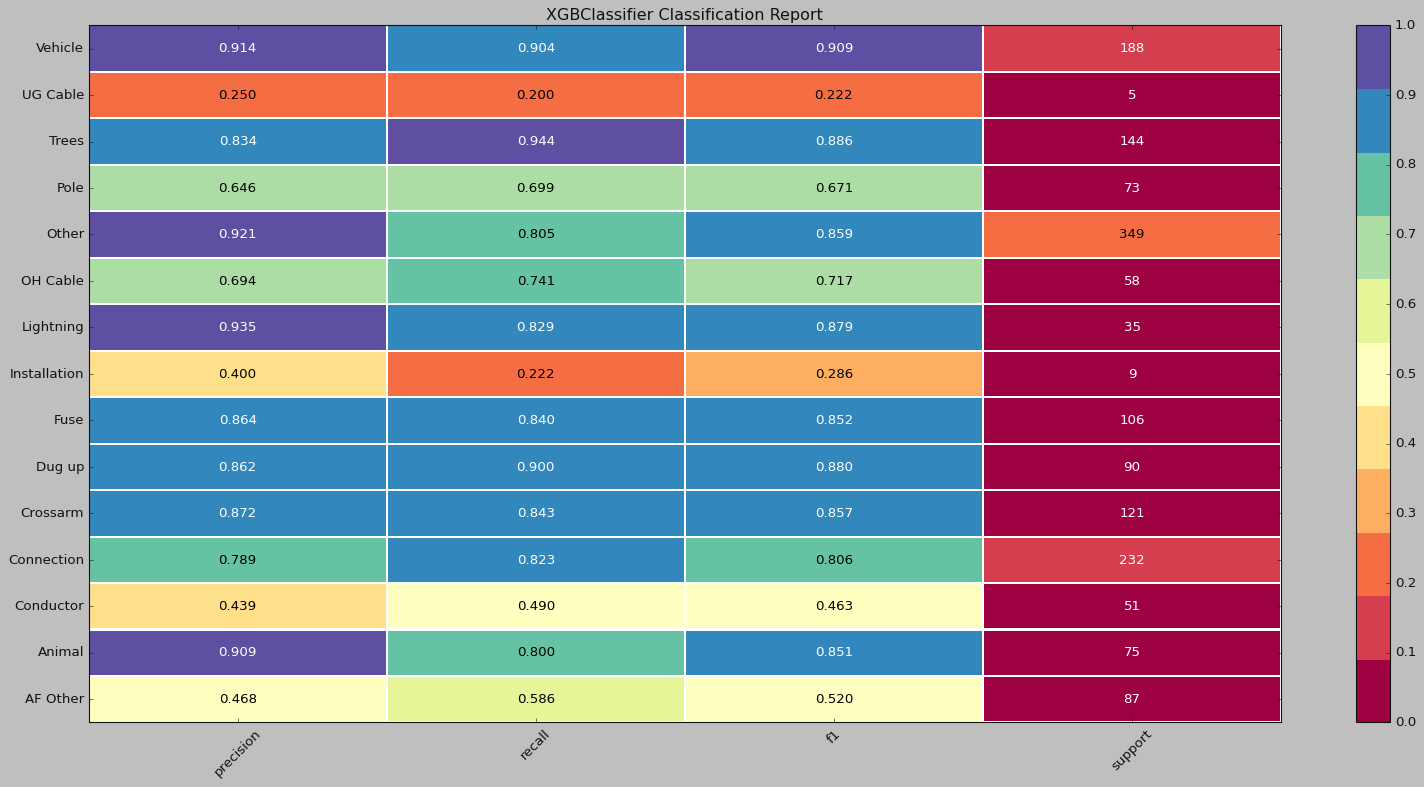

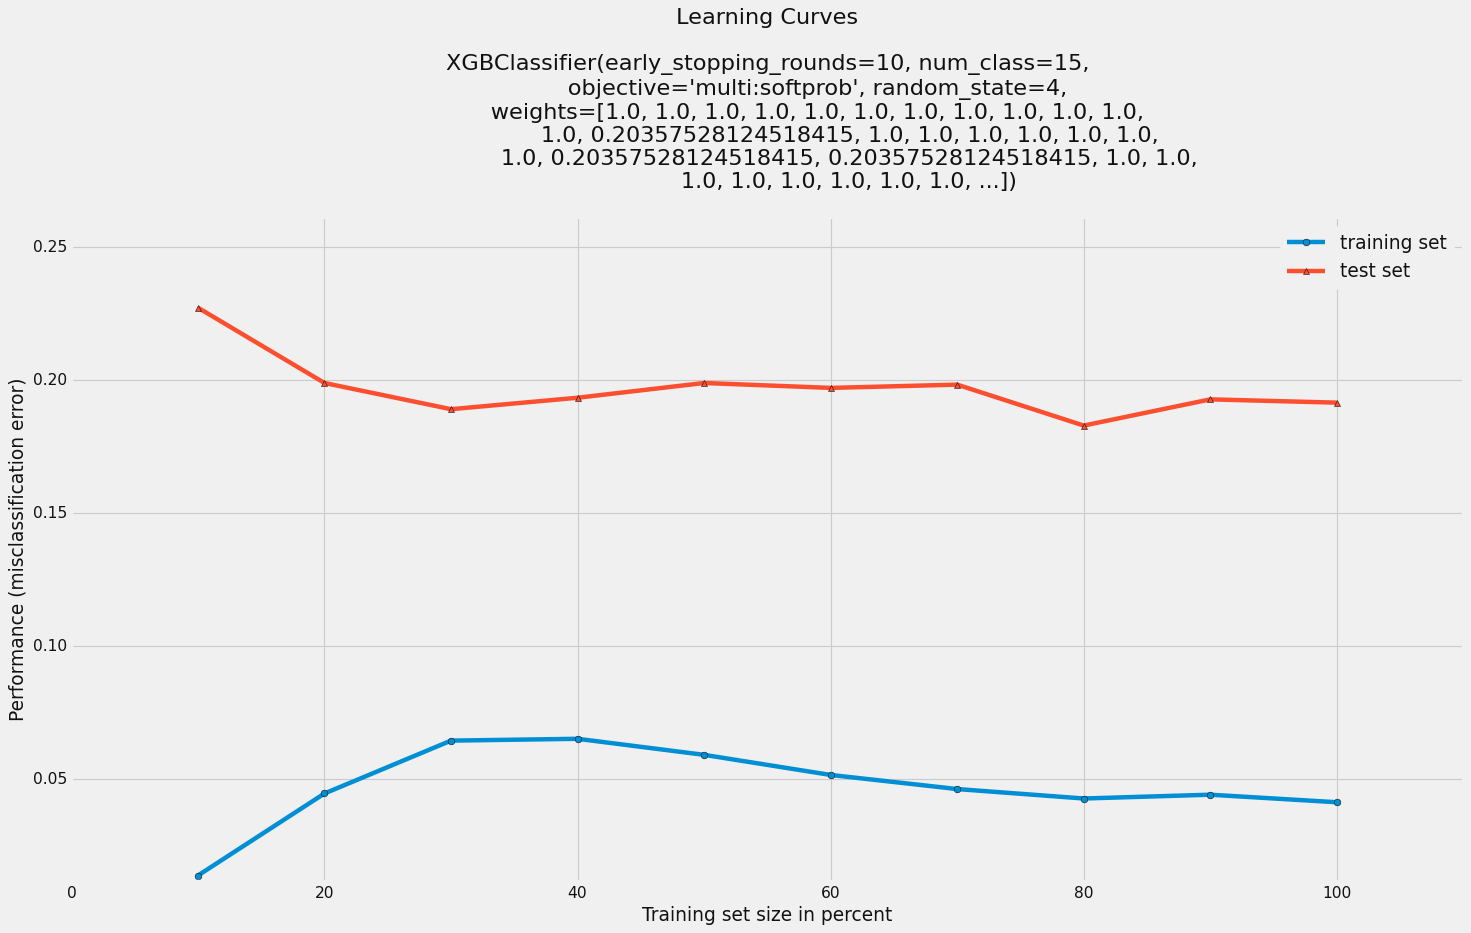

In [35]:
model_evaluation(xgb, x_train, y_train, x_test, y_test, 'xgBoost', y_pred)

In [6]:
# experiment with 500 features, no weight param
# this is the MODEL

xgb = XGBClassifier(random_state=4, num_class=15, early_stopping_rounds=10) #500 features
xgb.fit(x_train, y_train)
y_pred = xgb.predict(x_test)

In [7]:
# dump model
model_pickle_name = 'XGB.pickle'
pickle.dump(xgb, open(model_pickle_name, 'wb'))

The accuracy for xgBoost: 0.8083795440542206
F-Measure for xgBoost: 0.8083795440542206


C:\Users\Mama\apps\Anaconda3\lib\site-packages\sklearn\base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


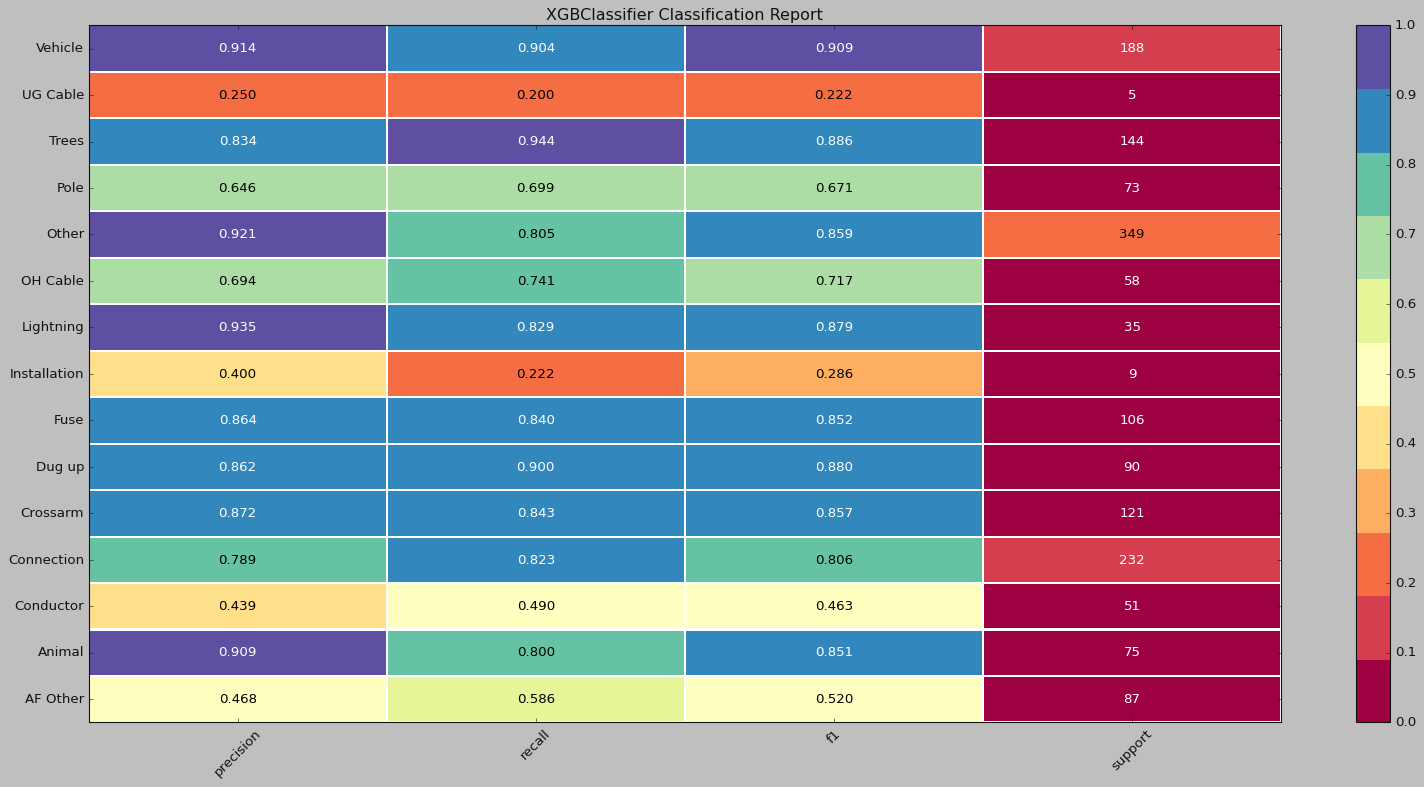

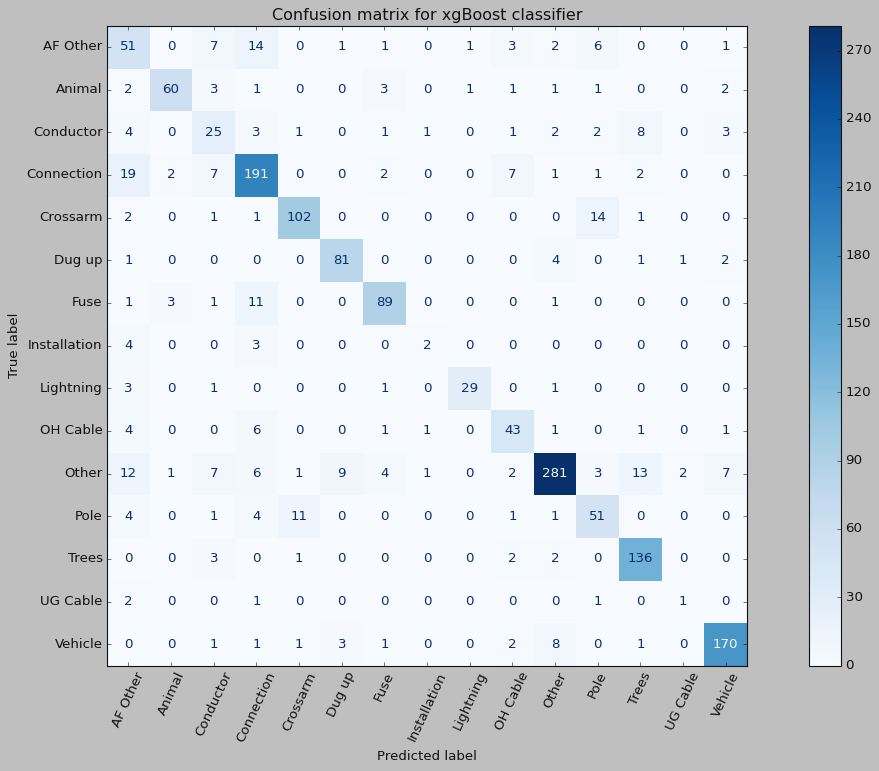

C:\Users\Mama\apps\Anaconda3\lib\site-packages\yellowbrick\classifier\prcurve.py:259: YellowbrickWarning: micro=True is ignored;specify per_class=False to draw a PR curve after micro-averaging
  YellowbrickWarning,
C:\Users\Mama\apps\Anaconda3\lib\site-packages\yellowbrick\style\colors.py:142: UserWarning: both colormap and colors specified; using colors
  warnings.warn("both colormap and colors specified; using colors")


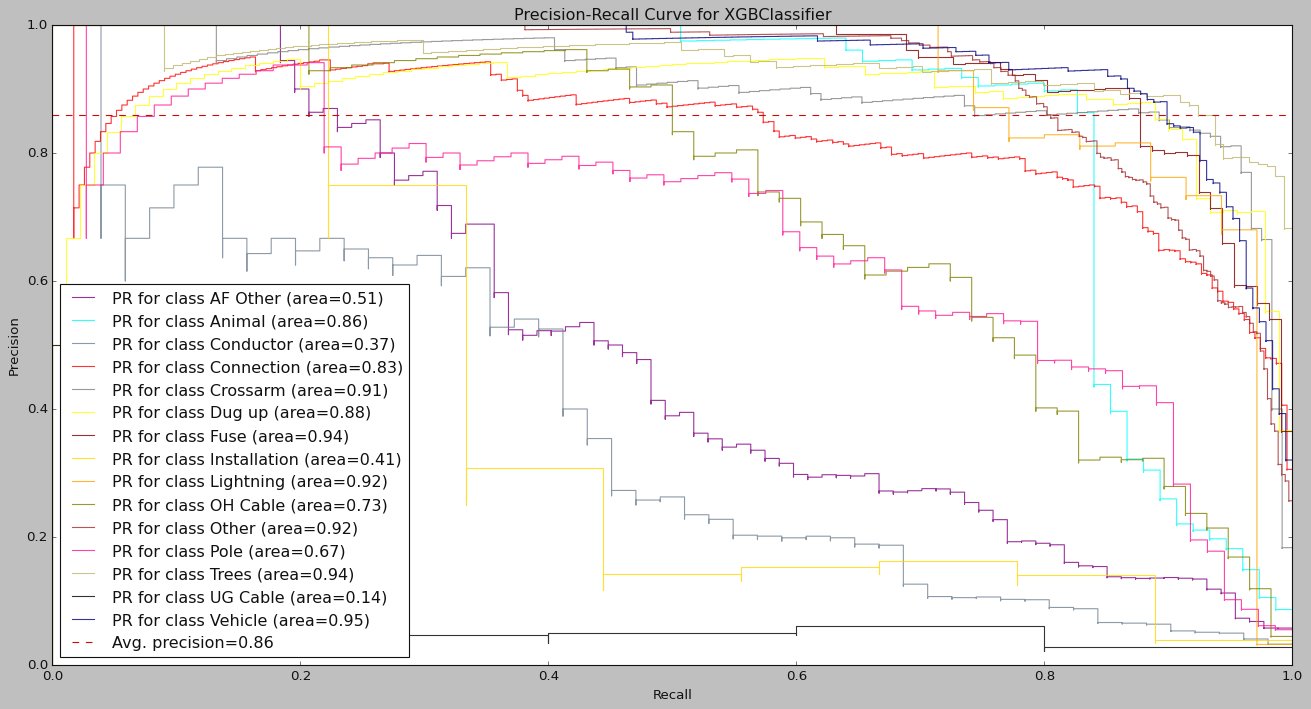

C:\Users\Mama\apps\Anaconda3\lib\site-packages\sklearn\base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


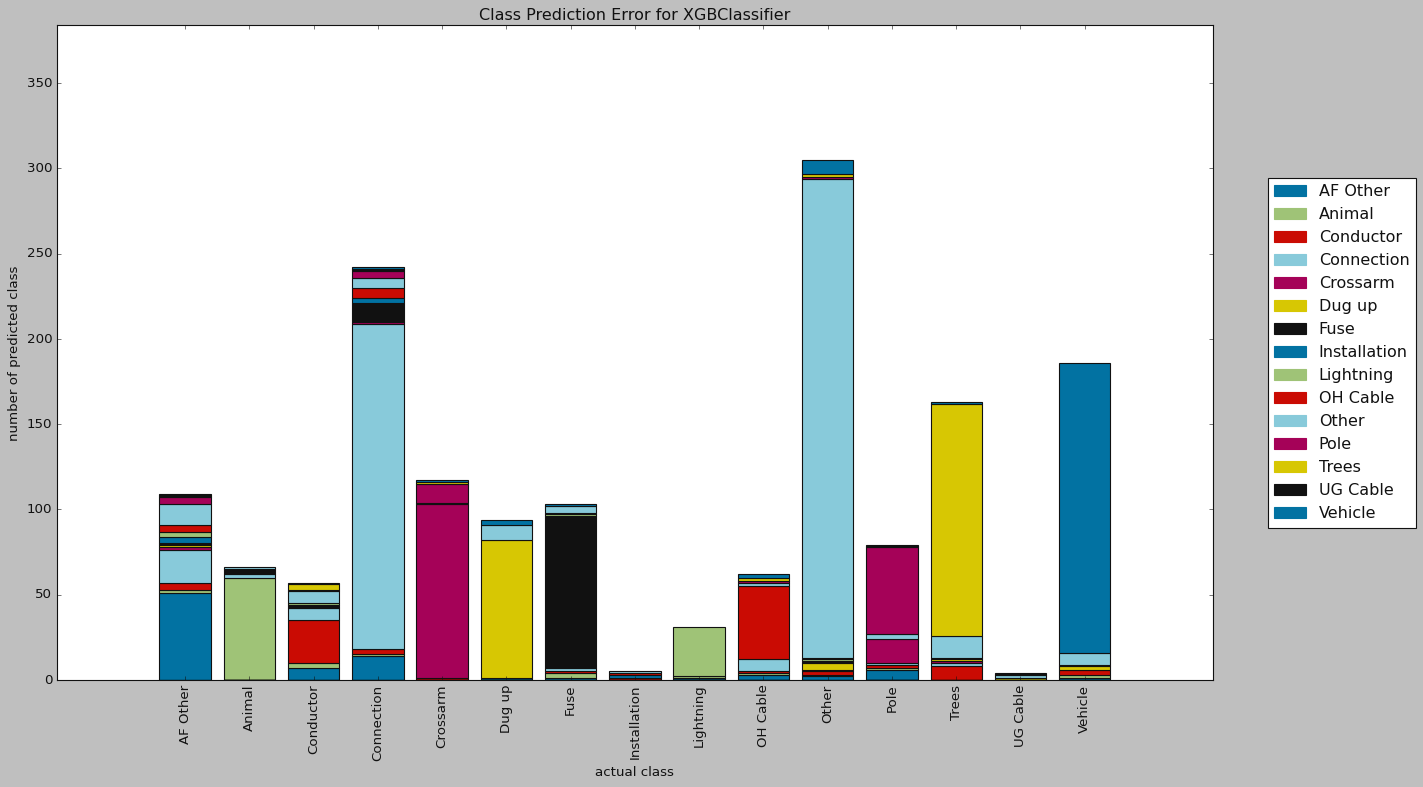

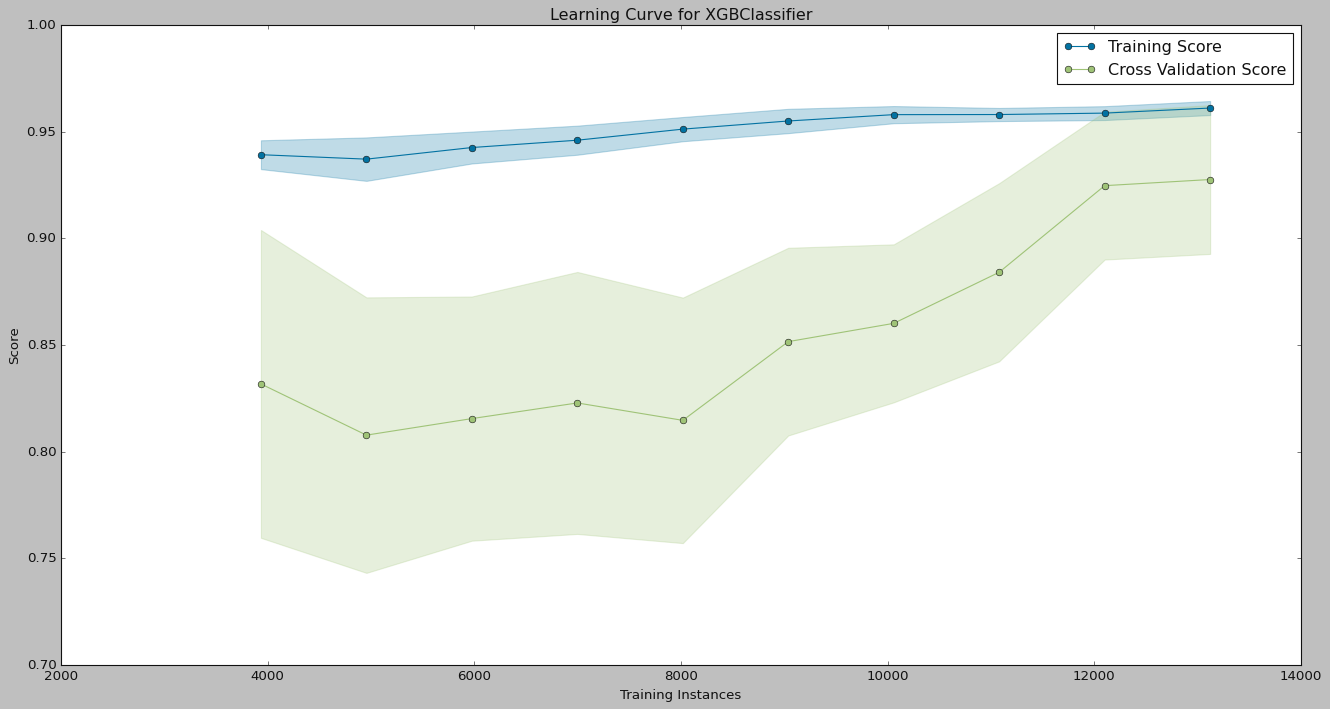

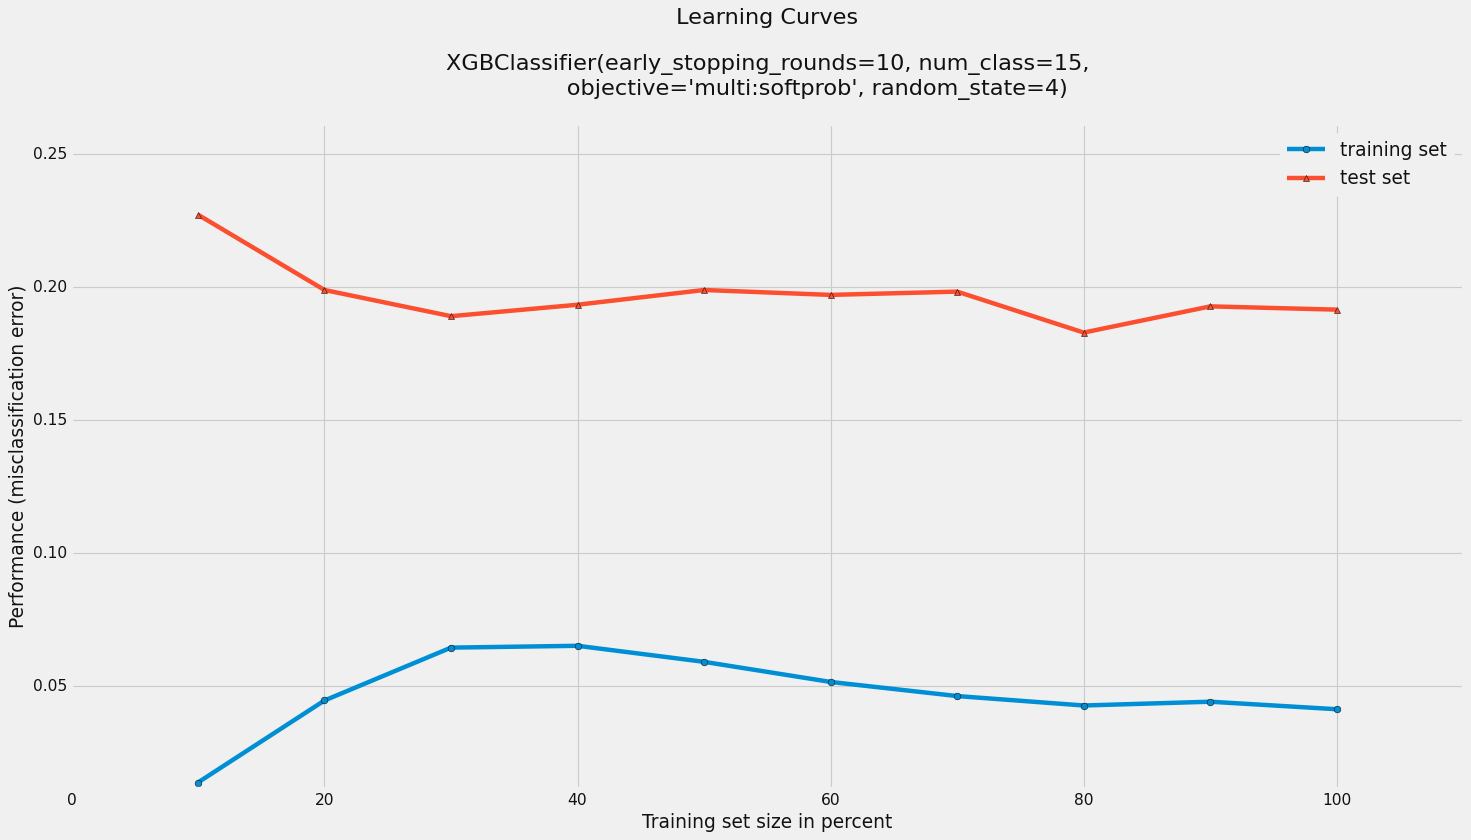

In [45]:
# plot model evaluation
model_evaluation(xgb, x_train, y_train, x_test, y_test, 'xgBoost', y_pred)

In [54]:
# other evaluations

# precision
precision = precision_score(y_test, y_pred, average="micro")
print(f'Precision: {precision}')

# recall
recall = recall_score(y_test, y_pred, average='micro')
print(f'Recall: {recall}')

Precision: 0.8083795440542206
Recall: 0.8083795440542206


The accuracy for xgBoost: 0.7868145409735059
F-Measure for xgBoost: 0.7868145409735059


C:\Users\Mama\apps\Anaconda3\lib\site-packages\sklearn\base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


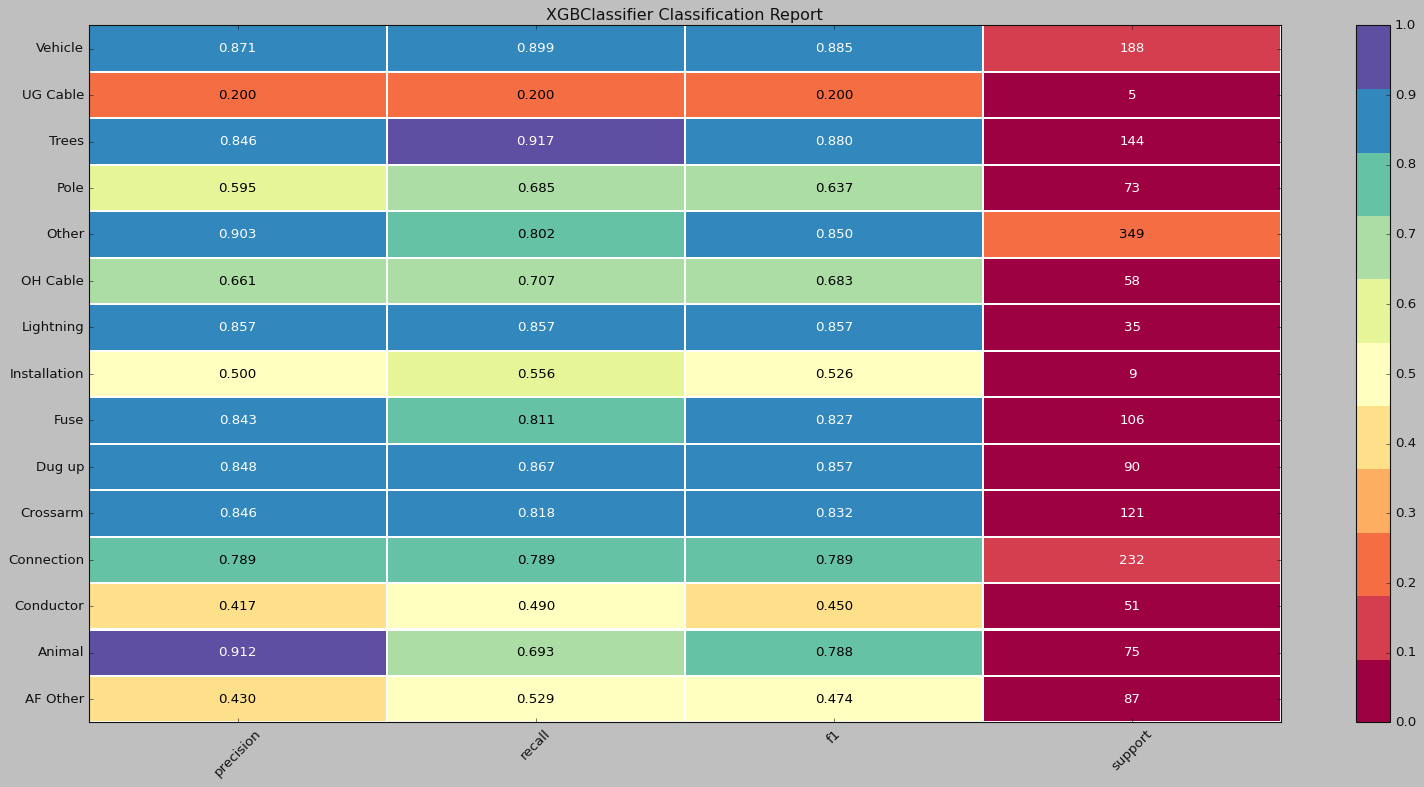

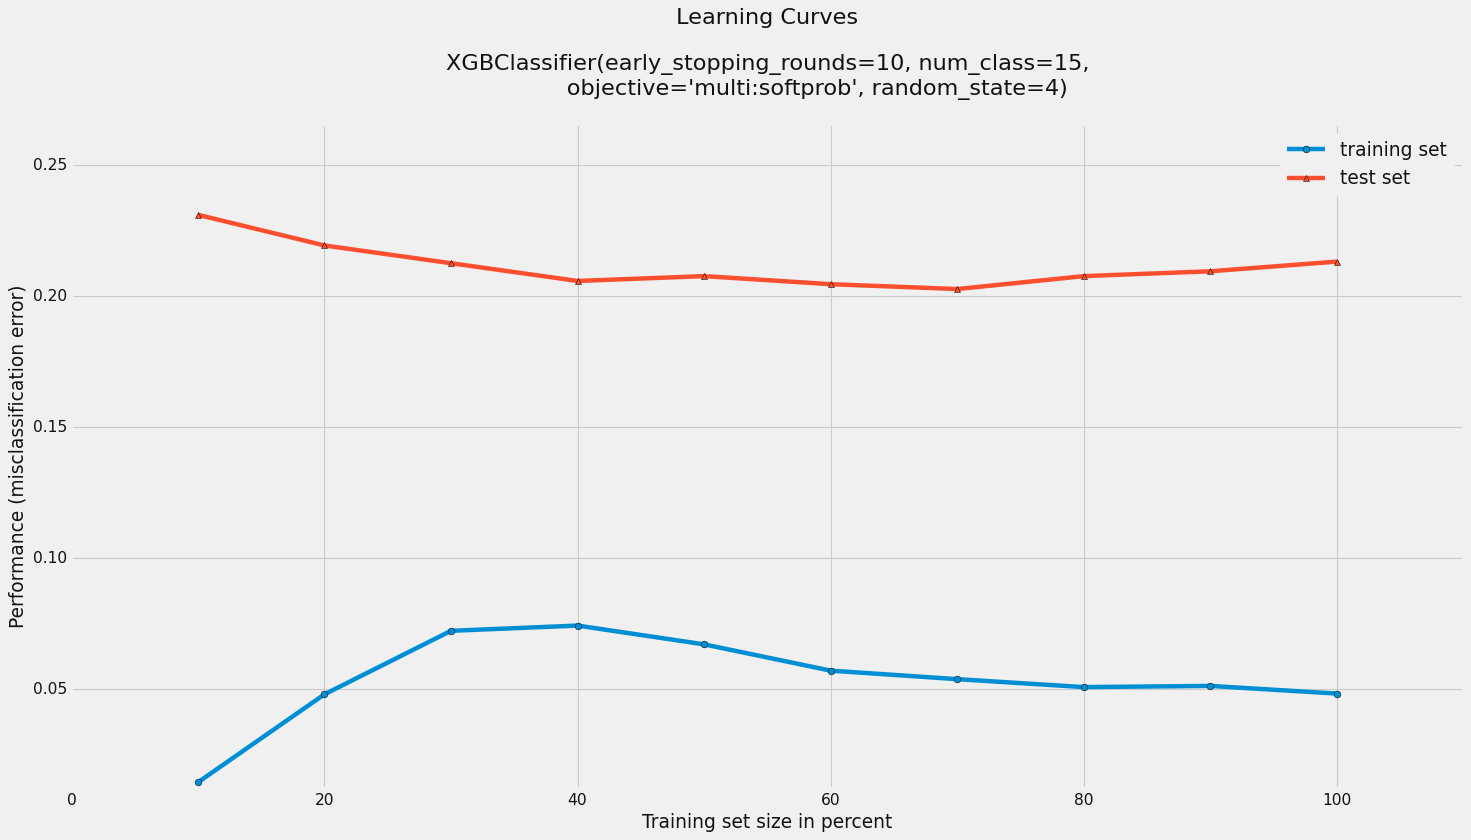

In [41]:
# experiment with 250 features, the accuracy is low and test line starts to go up at the end
xgb = XGBClassifier(random_state=4, num_class=15, early_stopping_rounds=10) #250 features
xgb.fit(x_train, y_train)
y_pred = xgb.predict(x_test)
model_evaluation(xgb, x_train, y_train, x_test, y_test, 'xgBoost', y_pred)

In [9]:
# Optimization

# default max_depth = 6, more depth is more complex, it can cause overfit
# default learning_rate: 0.3, reducing the learning rate to overcome overfitting
# default subsample=1.0, reducing subsample will reduce variance
# The higher Gamma is, the higher the regularization. Default value is 0

# grid search
param_grid = {
    'learning_rate': [0.001, 0.10, 0.30],
    'max_depth' : [6, 10, 20, 30],
    'gamma' : [0.1, 0.2],
    'subsample': [0.5, 0.7, 1.0]
}
best_model = GridSearchCV(estimator=XGBClassifier(random_state=4),
                      param_grid=param_grid, cv= 5, n_jobs=-1)
best_model.fit(x_train, y_train)
best_model.best_params_

{'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 20, 'subsample': 0.7}

In [9]:
# this method is in webapp
def preprocess_text_webapp(text):
    """
    Curently in use for following classifiers:
    - Random Forest, SGD, SVC, RNN, LR
    """
    # cleaning steps
    cleaning_pipeline = [preprocessing.fillna, preprocessing.lowercase, preprocessing.remove_whitespace,
                         preprocessing.remove_punctuation, preprocessing.remove_urls, preprocessing.remove_brackets,
                         preprocessing.remove_stopwords, preprocessing.remove_digits,
                         preprocessing.remove_angle_brackets, preprocessing.remove_curly_brackets, preprocessing.stem]

    # apply pipeline to text
    text = pd.Series(text)
    clean_text = text.pipe(hero.clean, cleaning_pipeline)

    return clean_text

In [11]:
# test pickles

TFIDF_500 = pickle.load(open(tfidf_pickle_name, "rb"))
xgb_model = pickle.load(open(model_pickle_name, "rb"))

sentence = "A car smashed into a pole which caused fire. No one was injured in the incident."

sentence = preprocess_text_webapp(sentence)

# Using loaded count vectorizer on it
tfidf_sentence = TFIDF_500.transform(sentence)

category = xgb_model.predict(tfidf_sentence)
print(category)

probability = xgb_model.predict_proba(tfidf_sentence)
print(probability)

[14]
[[0.29478157 0.01370516 0.03267921 0.07797565 0.01391331 0.00506345
  0.01314889 0.00947519 0.00269602 0.02134643 0.09137754 0.11769787
  0.00714488 0.00349558 0.29549924]]


Interpretation:

Accuracy, F1 score, precision and recall scores are above 80%. 
In Confusion matrix, there is no zero. It means the model has capability to predict minority classes
In Precision recall curve, most AUC scores are above 50%, however some minority classes have scores below 50%
In Class prediction error graph, all Categories have high probabilities for the right prediction
In Learning curve score graph, along with more data, both training and cv scores are improving, until they flat out that shows that adding more data may no longer improving the score.
In Learning curve classification error, both lines go down as the training data increases. It shows the high variance because the gap between train and test. However the test error has flatten at the end.
The model uses 500 max_feature in TF-IDF and SMOTE. We use default params and add a param early_stopping 10 to avoid overfitting